### Differential evolution algorithm for multiple component fitting

Brute-forcing the parameter space - a method that currently forms the basis of `multicube` repository - is a very simple concept, easy to grasp and straightforward to implement. However, for large spectra with thousands of channels, and for moderate (> 10) dimensionalities, the computational time required to sample an accurate starting point for each spectrum blows up through the roof. This can be tacked by two ways:

1. Smarter sampling of the parameter space guesses. Indeed, a careful selection of the guessing grid to iterate over should normally result in an adequate solution from `pyspeckit.fiteach`. However, strong prior knowledge is required in this case to constrain the problem at hand. In case of spectral cube fitting, this means that one can simply overlook a spectral component, decreasing the overall fit residual.
2. Make use of other minimization techniques that are *not sensitive to initial conditions*, as is gradient descent-like algorithms. Differential evolution, genetic algorithms, nested sampling, and Gaussian mixture model methods are all possible ways to reduce the complexity of fitting "tricky" spectral cubes with spatial discontinuities.
3. This notebook demonstrates the use of **differential evolution** technique as an alternative for more complex cases that can't be easily solved with `multicube`. This doesn't really rely on `multicube` brute force hacking, and is more of a nice direcet application of spectral functions already implemented in `pyspectkit`.

#### What is differential evolution?

It is a method that resamples and evolves randomly drawn parameter vectors until a good enough solution is found. Should result in a good solution for spectra that aren't too noisy. The resultant optimized global solution is then fine-tuned with a good old LM fitter.

This section probably needs to be expanded. For the time being, [here is a good starting reference point](http://stackoverflow.com/questions/7493781/explain-the-differential-evolution-method).

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pyspeckit
from multicube.subcube import SubCube
from multicube.astro_toolbox import make_test_cube, get_ncores
from IPython.utils import io
import warnings
warnings.filterwarnings('ignore')

make_test_cube((300, 10, 10), outfile='foo.fits', sigma=(10, 5))
sc = SubCube('foo.fits')

def tinker_ppv(arr):
    scale_roll, rel_shift, rel_str = 15, 30, 5
    shifted_component = np.roll(arr, rel_shift) / rel_str
    for y,x in np.ndindex(arr.shape[1:]):
        roll  = np.sqrt((x - 5)**2 + (y - 5)**2) * scale_roll
        arr[:, y, x] = np.roll(arr[:, y, x], int(roll))
    return arr + shifted_component
sc.cube = tinker_ppv(sc.cube)

The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


In [2]:
# setting up the model
npeaks = 2
sc.update_model('gaussian')
sc.specfit.fitter.npeaks = npeaks
ndims = sc.specfit.fitter.npars * sc.specfit.fitter.npeaks

INFO: Selected gaussian model [multicube.subcube]


In [35]:
from astropy.utils.console import ProgressBar
from scipy.optimize import differential_evolution

bounds = [[0, 4], [sc.xarr.value.min(), sc.xarr.value.max()], [0, 4]]*npeaks
sc.parcube = np.empty(shape=(ndims,) + sc.cube.shape[1:])
for x,y in ProgressBar(list(np.ndindex(sc.cube.shape[1:])),
                      ipython_widget=True):
    sp = sc.get_spectrum(x, y)
    resid = lambda pars: ((sp.specfit.get_full_model(pars=pars) - sp.data)**2).sum()
    res = differential_evolution(resid, bounds=bounds)
    sc.parcube[:, y, x] = res.x

### Fitting the cube best models for each x,y pixel:

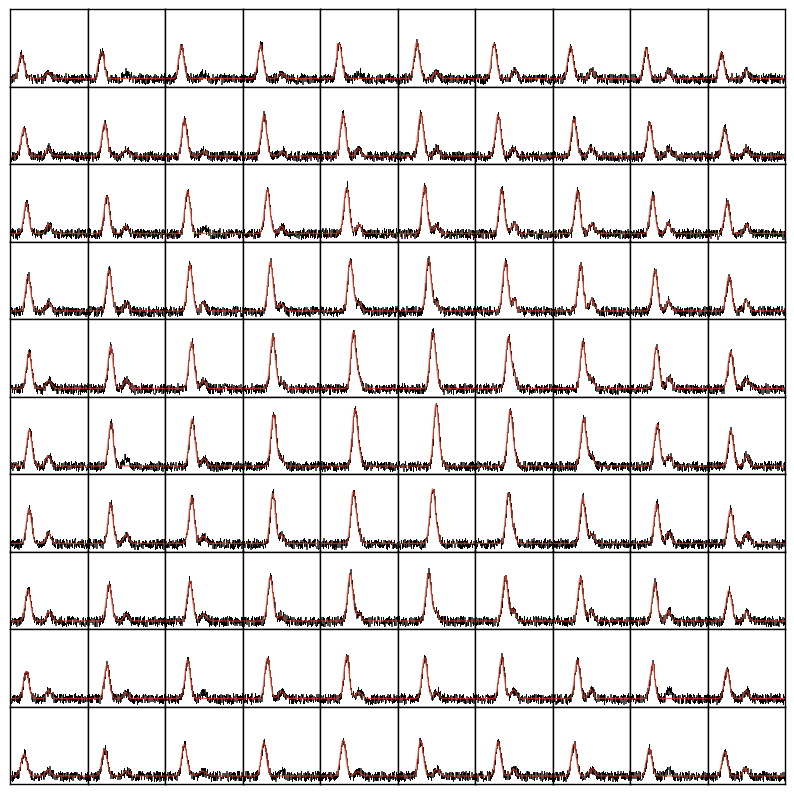

In [40]:
sc.get_modelcube()
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(*sc.cube.shape[1:])
gs.update(wspace=0., hspace=0.)
for ii in range(np.prod(sc.cube.shape[1:])):
    xy = np.unravel_index(ii, dims=sc.cube.shape[1:])
    ax = plt.subplot(gs[ii])
    sc.plot_spectrum(*xy, axis=ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_ylim(-0.15, 1.3)
    ax.plot(sc.xarr.value, sc._modelcube[:, xy[1], xy[0]], color='#f03b20', alpha=0.7)

#### How good is it?

9% of the secondary spectra are **not** detected. Perhaps running the DE on defaults isn't ideal. Overall this looks promising, but brute-forcing seems to fit the weak component better so far.

Also, wouldn't it be nice to have `differential_evolution` parallelised? This way we can have it through `multiprocessing`...